In [7]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model

In [8]:
class AgentsState(MessagesState):
    current_agent: str
    transfered_by: str


llm = init_chat_model("openai:gpt-4o")


In [9]:
def make_agent(prompt, tools):
    def agent_node(state: AgentsState):
        llm_with_tools = llm.bind_tools(tools)
        response = llm_with_tools.invoke(
            f"""
            {prompt}

            Conversation History:
            {state["messages"]}
            """
        )
        return {"messages": [response]}

    agent_builder = StateGraph(AgentsState)

    (
        agent_builder
        .add_node("agent", agent_node)
        .add_node("tools", ToolNode(tools=tools))

        .add_edge(START, "agent")
        .add_conditional_edges("agent", tools_condition)
        .add_edge("tools", "agent")
        .add_edge("agent", END)
    )
    return agent_builder.compile()


In [10]:
@tool
def handoff_tool(transfer_to: str, transfered_by: str):
    """
     Handoff to another agent.

     Use this tool when the customer speaks a language that you don't understand.

     Possible values for `transfer_to`:
     - `korean_agent`
     - `greek_agent`
     - `spanish_agent`

     Possible values for `transfered_by`:
     - `korean_agent`
     - `greek_agent`
     - `spanish_agent`

     Args:
         transfer_to: The agent to transfer the conversation to
         transfered_by: The agent that transferred the conversation
     """
    return Command(
        update={
            "current_agent": transfer_to,
            "transfered_by": transfered_by,
        },
        goto=transfer_to,
        graph=Command.PARENT
    )

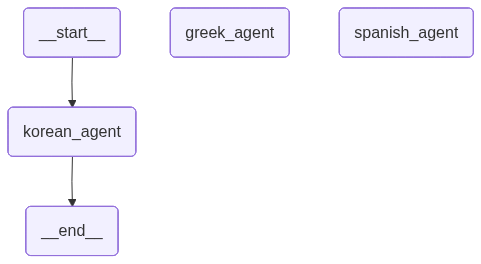

In [11]:
graph_builder = StateGraph(AgentsState)

(
    graph_builder

    .add_node("korean_agent", make_agent(
        prompt="You're a Korean customer support agent. You only speak and understand Korean.",
        tools=[handoff_tool]))

    .add_node("greek_agent", make_agent(
        prompt="You're a Greek customer support agent. You only speak and understand Greek.",
        tools=[handoff_tool]))

    .add_node("spanish_agent", make_agent(
        prompt="You're a Spanish customer support agent. You only speak and understand Spanish.",
        tools=[handoff_tool]))

    .add_edge(START, "korean_agent")
)
graph = graph_builder.compile()

display(graph)